In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# mount google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Clarviate used the following master journal list for calculating the jif released in 2023. These journals are selected based on Web of Science criteria (https://clarivate.com/news/clarivate-unveils-journal-citation-reports-2023-a-trusted-resource-to-support-research-integrity-and-promote-accurate-journal-evaluation/)

In [ ]:
master_journals_list = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/validation_data/wos_master_journal_list.csv')
master_journals_list.drop(axis=1,labels='Unnamed: 0',inplace=True)
master_journals_list.duplicated().sum() # 0 duplicated rows
print(len(master_journals_list))
master_journals_list.head()

23319


,Journal title,ISSN,eISSN,Publisher name,Publisher address,Languages,Web of Science Categories,Web of Science Collection
0,2D MATERIALS,2053-1583,2053-1583,IOP PUBLISHING LTD,"TEMPLE CIRCUS, TEMPLE WAY, BRISTOL, ENGLAND, B...",English,"Materials Science, Multidisciplinary",SCIE
1,3 BIOTECH,2190-572X,2190-5738,SPRINGER HEIDELBERG,"TIERGARTENSTRASSE 17, HEIDELBERG, GERMANY, D-6...",English,Biotechnology & Applied Microbiology,SCIE
2,3D PRINTING AND ADDITIVE MANUFACTURING,2329-7662,2329-7670,"MARY ANN LIEBERT, INC","140 HUGUENOT STREET, 3RD FL, NEW ROCHELLE, USA...",English,"Engineering, Manufacturing | Materials Science...",SCIE
3,4OR-A QUARTERLY JOURNAL OF OPERATIONS RESEARCH,1619-4500,1614-2411,SPRINGER HEIDELBERG,"TIERGARTENSTRASSE 17, HEIDELBERG, GERMANY, D-6...",English,Operations Research & Management Science,SCIE
4,AAPG BULLETIN,0149-1423,1558-9153,AMER ASSOC PETROLEUM GEOLOGIST,"1444 S BOULDER AVE, PO BOX 979, TULSA, USA, OK...",English,"Geosciences, Multidisciplinary",SCIE


For the first time, Arts and Humanities journals were included and recieved a JIF in the 2023 JCR release.

In [ ]:
master_journals_list["Web of Science Collection"].value_counts()

Web of Science Collection
SCIE    9482
ESCI    8460
SSCI    3551
AHCI    1826
Name: count, dtype: int64

Read in data for calculting JIF with Open Alex data. Need number of papers journals' published in 2021 and 2020. And number of citations recieved in 2022 to papers published in 2020 and 2021. Also need ISSN to compare with the master journals list.

In [ ]:
publishers = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/df_publisher.csv')
publishers.drop('Unnamed: 0',axis=1,inplace=True)
publishers.dropna(inplace=True,axis=0,subset='issn_string')

# open alex provides multiple issns in some cases, split the list of strings into separate columns for merging
publishers['issn_string'] = publishers['issn_string'].str.split(',')
split = pd.DataFrame(publishers.issn_string.values.tolist(),publishers.journal_id).add_prefix('issn_'); split.reset_index(inplace=True)
publishers = publishers.merge(split,on='journal_id')
print(len(publishers))
publishers.head()

21977


,Unnamed: 0.1,type,w_count20,w_count21,level_0_concepts_scores,main_concept,journal_id,display_name,issn_string,workcount20_recalc,...,issn_1,issn_2,issn_3,issn_4,issn_5,issn_6,issn_7,issn_8,issn_9,issn_10
0,0,journal,0,0,"{'Art': 33.0, 'Biology': 22.7, 'Business': Non...",Medicine,4210179293,Theoretical Medicine And Bioethics,"[0166-2031, 1573-1200]",0,...,1573-1200,None,None,None,None,None,None,None,None,None
1,1,journal,13,9,"{'Art': 85.9, 'Biology': None, 'Business': Non...",Philosophy,118387496,Studia Monastica,[0039-3258],13,...,None,None,None,None,None,None,None,None,None,None
2,2,journal,0,1,"{'Art': 84.6, 'Biology': 22.2, 'Business': Non...",Philosophy,2764591912,Journal of Northwest Semitic Languages,[0259-0131],0,...,None,None,None,None,None,None,None,None,None,None
3,3,journal,0,9,"{'Art': 72.3, 'Biology': 138.3, 'Business': No...",Psychology,4210220261,Malaysian Journal of ELT Research,[2716-6414],0,...,None,None,None,None,None,None,None,None,None,None
4,4,journal,20,1,"{'Art': 46.7, 'Biology': 22.3, 'Business': Non...",History,51144040,International Journal of Intangible Heritage,"[1975-3586, 1975-4019]",20,...,1975-4019,None,None,None,None,None,None,None,None,None


Using the ISSN values to merge, get the list of open alex ids for journals in clarviate's master journals list.

In [ ]:
print(len(master_journals_list))
pd.options.mode.copy_on_write = True # deals with warnings

m0 = publishers[['journal_id','issn_0','main_concept']]
m0 = master_journals_list.merge(m0,left_on='ISSN',right_on='issn_0')
m0.rename({'issn_0':'issn_merge'},axis=1,inplace=True)

for i in tqdm(range(1,11)):
  issn_str = str('issn_'+str(i))
  m1 = publishers[['journal_id',issn_str,'main_concept']]
  m1.dropna(axis=0,inplace=True,how='any')
  m1 = master_journals_list.merge(m1,left_on='ISSN',right_on=issn_str)
  m1.rename({issn_str:'issn_merge'},axis=1,inplace=True)
  m0 = pd.concat([m0,m1])
  m0.drop_duplicates(subset='journal_id',inplace=True)

for i in tqdm(range(0,11)):
  issn_str = str('issn_'+str(i))
  m1 = publishers[['journal_id',issn_str,'main_concept']]
  m1.dropna(axis=0,inplace=True,how='any')
  m1 = master_journals_list.merge(m1,left_on='eISSN',right_on=issn_str)
  m1.rename({issn_str:'issn_merge'},axis=1,inplace=True)
  m0 = pd.concat([m0,m1])
  m0.drop_duplicates(subset='journal_id',inplace=True)

master_journals_list = m0; del m0
print(len(master_journals_list))

master_journals_list.head()

23319


100%|██████████| 11/11 [00:00<00:00, 52.35it/s]


21347


,Journal title,ISSN,eISSN,Publisher name,Publisher address,Languages,Web of Science Categories,Web of Science Collection,journal_id,issn_merge,main_concept
0,2D MATERIALS,2053-1583,2053-1583,IOP PUBLISHING LTD,"TEMPLE CIRCUS, TEMPLE WAY, BRISTOL, ENGLAND, B...",English,"Materials Science, Multidisciplinary",SCIE,4210229423,2053-1583,Physics
1,AAPS JOURNAL,1550-7416,1550-7416,SPRINGER,"ONE NEW YORK PLAZA, SUITE 4600 , NEW YORK, Uni...",English,Pharmacology & Pharmacy,SCIE,74983066,1550-7416,Biology
2,AAPS PHARMSCITECH,1530-9932,1530-9932,SPRINGER,"ONE NEW YORK PLAZA, SUITE 4600 , NEW YORK, Uni...",English,Pharmacology & Pharmacy,SCIE,1234972,1530-9932,Chemistry
3,AATCC REVIEW,1532-8813,1532-8813,AMER ASSOC TEXTILE CHEMISTS COLORISTS-AATCC,"1 DAVID DR, PO BOX 12215, RES TRIANGLE PK, USA...",English,"Chemistry, Applied | Engineering, Chemical | M...",SCIE,97859287,1532-8813,Materials science
4,ABDOMINAL RADIOLOGY,2366-004X,2366-0058,SPRINGER,"ONE NEW YORK PLAZA, SUITE 4600 , NEW YORK, Uni...",English,"Radiology, Nuclear Medicine & Medical Imaging",SCIE,131800149,2366-004X,Medicine


## Using text analysis try to match more journals



In [ ]:
# get a list of the unmatched journal titles

# all journals in WOS master journals list
raw = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/validation_data/wos_master_journal_list.csv')
raw.drop('Unnamed: 0',axis=1,inplace=True)

# journals from this ^ list that WERE able to be matched
matched = master_journals_list.drop(axis=1,labels=['journal_id','issn_merge','main_concept'])
matched_ids = master_journals_list['journal_id'].to_list()

# unmatched journals
unmatched = pd.concat([raw,matched])
print(len(unmatched))
print(unmatched.duplicated(keep=False).sum())
unmatched.drop_duplicates(ignore_index=True, keep=False, subset=['Journal title','ISSN','eISSN','Publisher name'], inplace=True) # by default removes duplicate rows based on all columns,
len(unmatched)

44666
42145


1340

In [ ]:
# remove matched journals from the publishers df so we don't match ones that have already been matched
publishers_temp = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/df_publisher.csv')
print(len(publishers_temp))
publishers_temp = publishers_temp[~publishers_temp['journal_id'].isin(matched_ids)]
len(publishers_temp)

22184


837

In [ ]:
# find the unmatched titles in the publishers df
import re, string, timeit

# lower case all titles
unmatched['title_cleaned'] = unmatched['Journal title']
unmatched['title_cleaned'] = unmatched['title_cleaned'].map(lambda x: x.lower())
unmatched['title_cleaned'] = unmatched['title_cleaned'].str.replace("[^a-zA-Z]+", " ")
unmatched['title_cleaned'] = unmatched['title_cleaned'].str.replace("and", " ")

publishers_temp['title_cleaned'] = publishers_temp['display_name']
publishers_temp.dropna(inplace=True,axis=0,subset='title_cleaned')
publishers_temp['title_cleaned'] = publishers_temp['title_cleaned'].map(lambda x: x.lower())
publishers_temp['title_cleaned'] = publishers_temp['title_cleaned'].str.replace("[^a-zA-Z]+", " ")
publishers_temp['title_cleaned'] = publishers_temp['title_cleaned'].str.replace("and", " ")
to_merge = publishers_temp[['journal_id','title_cleaned','main_concept']]

merge = unmatched.merge(to_merge,on='title_cleaned')
merge.drop(axis=1,labels='title_cleaned',inplace=True)
merge['issn_merge'] = None
print(len(merge))

merge.head()

713


,Journal title,ISSN,eISSN,Publisher name,Publisher address,Languages,Web of Science Categories,Web of Science Collection,journal_id,main_concept,issn_merge
0,AAPG BULLETIN,0149-1423,1558-9153,AMER ASSOC PETROLEUM GEOLOGIST,"1444 S BOULDER AVE, PO BOX 979, TULSA, USA, OK...",English,"Geosciences, Multidisciplinary",SCIE,144020083,Geology,None
1,ACM TRANSACTIONS ON INFORMATION SYSTEMS,1046-8188,1558-2868,ASSOC COMPUTING MACHINERY,"1601 Broadway, 10th Floor, NEW YORK, Usa, NY, ...",English,"Computer Science, Information Systems",SCIE,87067389,Computer science,None
2,ACTA BIOQUIMICA CLINICA LATINOAMERICANA,0325-2957,1851-6114,FEDERACION BIOQUIMICA PROVINCIA BUENOS AIRES,"CALLE 6, NO. 1344, LA PLATA, BUENOS AIRES, ARG...",Spanish,Medical Laboratory Technology,SCIE,168289741,Medicine,None
3,ACTA BOTANICA MEXICANA,NaN,2448-7589,INST ECOLOGIA AC,"CENTRO REGIONAL DEL BAJIO, APARTADO POSTAL 386...",Spanish,Plant Sciences,SCIE,189988577,Biology,None
4,ACTA MATHEMATICA HUNGARICA,0236-5294,1588-2632,SPRINGER,"VAN GODEWIJCKSTRAAT 30, DORDRECHT, NETHERLANDS...",English,Mathematics,SCIE,12965339,Mathematics,None


In [ ]:
master_journals_list = pd.concat([master_journals_list,merge])
master_journals_list.drop_duplicates(subset='journal_id',inplace=True,keep='first')
len(master_journals_list)

22060

In [ ]:
# save matched open alex journal ids for filtering purposes
master_journals_list['journal_id'].to_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/validation_data/wos_mjl_matched_ids.csv')

Cycle through papers metadata and paper/publisher dict to count citations.

First cycle through papers metadata and save all 2022 papers from this master journals list, then we'll look at their references.

In [ ]:
journal_ids = master_journals_list['journal_id'].unique()
type(journal_ids[0])

numpy.int64

In [ ]:
papers = pd.read_parquet('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df0.parquet')
papers.head()

,referenced_works,is_retracted,publication_year,journal_id,openalex
0,[],0,2020,None,4235739657
1,[],0,2021,4306489185,274148733
2,"[1971383779, 1998201250, 2019180996, 205001708...",0,2020,139212996,3003637715
3,"[2046717708, 2104548316, 2112136274, 211214791...",0,2020,161085503,3009875419
4,"[2012505332, 2021622102, 2062891727, 206457081...",0,2020,2764760790,3012650581


In [ ]:
# how many papers are there?
total = 0
for i in tqdm(range(0,45)):
  filename = str('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df'+str(i)+'.parquet')
  papers = pd.read_parquet(filename)
  total += len(papers)
# add on last df
papers = pd.read_parquet('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df_last45.parquet')
total+=len(papers)
print(str(total)+' papers used')

100%|██████████| 45/45 [04:57<00:00,  6.61s/it]


32217303 papers used


In [ ]:
pd.options.mode.copy_on_write = True

for i in tqdm(range(0,45)):

  filename = str('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df'+str(i)+'.parquet')
  papers = pd.read_parquet(filename)

  # can't have been retracted
  papers = papers[papers['is_retracted']!=1]
  # can't have null journal id
  papers = papers.dropna(axis=0,how='any',subset='journal_id')
  # can't have empty references
  papers = papers[papers['referenced_works'].map(lambda d: len(d)) > 0]
  # journal id must be in our final journals list
  papers['journal_id'] = papers['journal_id'].astype(int)
  papers = papers[papers['journal_id'].isin(journal_ids)]
  # must be published in 2022
  papers = papers[papers['publication_year']==2022]

  filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/papers_metadata/calculate_jif/file_df'+str(i)+'.parquet')
  papers.to_parquet(filename)

# add on "last" df
papers = pd.read_parquet('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df_last45.parquet')

# can't have been retracted
papers = papers[papers['is_retracted']!=1]
# can't have null journal id
papers = papers.dropna(axis=0,how='any',subset='journal_id')
# can't have empty references
papers = papers[papers['referenced_works'].map(lambda d: len(d)) > 0]
# journal id must be in our final journals list
papers['journal_id'] = papers['journal_id'].astype(int)
papers = papers[papers['journal_id'].isin(journal_ids)]
# must be published in 2022
papers = papers[papers['publication_year']==2022]

filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/papers_metadata/calculate_jif/file_df45.parquet')
papers.to_parquet(filename)

100%|██████████| 45/45 [05:52<00:00,  7.83s/it]


filter the work-publisher dict to only have publishers from the master journals list

In [ ]:
# filter work/publisher dictionaries to only have journals in the list

for i in tqdm(range(0,45)):
  filename = str('/content/drive/MyDrive/CitationsProject/2020_22_data/work_publisher_dict_rest_'+str(i)+'.json')
  f = open(filename)
  paper_journal = json.load(f)

  filter = pd.DataFrame({'journal_id':paper_journal.values(),'paper_id':paper_journal.keys()})

  filter = filter[filter['journal_id'].isin(journal_ids)]
  filter['journal_id'] = filter['journal_id'].astype(int)
  save_dict = dict(zip(filter['paper_id'], filter['journal_id']))

  filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/paper_journal_pairs/work_publisher_dict_rest_'+str(i)+'.json')
  with open(filename, "w") as fp:
    json.dump(save_dict, fp)

# last file
filename = str('/content/drive/MyDrive/CitationsProject/2020_22_data/work_publisher_dict_last45.json')
f = open(filename)
paper_journal = json.load(f)

filter = pd.DataFrame({'journal_id':paper_journal.values(),'paper_id':paper_journal.keys()})

filter = filter[filter['journal_id'].isin(journal_ids)]
filter['journal_id'] = filter['journal_id'].astype(int)
save_dict = dict(zip(filter['paper_id'], filter['journal_id']))

filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/paper_journal_pairs/work_publisher_dict_rest_45.json')
with open(filename, "w") as fp:
  json.dump(save_dict, fp)

100%|██████████| 45/45 [11:41<00:00, 15.60s/it]


filter work publisher dict to only have papers published in 2021-2020

In [ ]:
filename = str('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df0.parquet')
papers = pd.read_parquet(filename)
papers.head()

,referenced_works,is_retracted,publication_year,journal_id,openalex
0,[],0,2020,None,4235739657
1,[],0,2021,4306489185,274148733
2,"[1971383779, 1998201250, 2019180996, 205001708...",0,2020,139212996,3003637715
3,"[2046717708, 2104548316, 2112136274, 211214791...",0,2020,161085503,3009875419
4,"[2012505332, 2021622102, 2062891727, 206457081...",0,2020,2764760790,3012650581


In [ ]:
# get a list of papers published in 2020 or 2021 to filter the work-journal dicts to only have 2020-2021 papers
paper_ids = []

for i in tqdm(range(0,45)):

  filename = str('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df'+str(i)+'.parquet')
  papers = pd.read_parquet(filename)

  # can't have been retracted
  papers = papers[papers['is_retracted']!=1]
  # can't have null journal id
  papers = papers.dropna(axis=0,subset='journal_id')
  # journal id must be in our final journals list
  papers['journal_id'] = papers['journal_id'].astype(int)
  papers = papers[papers['journal_id'].isin(journal_ids)]
  # must be published in 2020 or 2021
  papers = papers[papers['publication_year']!=2022]

  paper_ids.append(papers['openalex'].to_list())

# add on "last" df
papers = pd.read_parquet('/content/drive/MyDrive/CitationsProject/2020_22_data/file_df_last45.parquet')
# can't have been retracted
papers = papers[papers['is_retracted']!=1]
# can't have null journal id
papers = papers.dropna(axis=0,how='any')
# journal id must be in our final journals list
papers['journal_id'] = papers['journal_id'].astype(int)
papers = papers[papers['journal_id'].isin(journal_ids)]
# must be published in 2022
papers = papers[papers['publication_year']!=2022]
paper_ids.append(papers['openalex'].to_list())

100%|██████████| 45/45 [04:56<00:00,  6.60s/it]


In [ ]:
# flatten
paper_ids = [item for row in paper_ids for item in row]
len(paper_ids)

8133967

In [ ]:
# filter work/publisher dictionaries to only have papers in the list

for i in tqdm(range(0,46)):
  filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/paper_journal_pairs/work_publisher_dict_rest_'+str(i)+'.json')
  f = open(filename)
  paper_journal = json.load(f)

  filter = pd.DataFrame({'journal_id':paper_journal.values(),'paper_id':paper_journal.keys()})

  filter = filter[filter['paper_id'].isin(paper_ids)]
  save_dict = dict(zip(filter['paper_id'], filter['journal_id']))

  filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/paper_journal_pairs/calculate_jif/work_publisher_dict_rest_'+str(i)+'.json')
  with open(filename, "w") as fp:
    json.dump(save_dict, fp)

100%|██████████| 46/46 [10:46<00:00, 14.06s/it]


1. look at the references in the papers file
2. check which journal they occur in in the master journals list
3. add +1 citation count 22

In [ ]:
# storing citation count 22
master_journals_list['citations22'] = 0
master_journals_list.index = master_journals_list['journal_id']

In [ ]:
# merge the paper-journal dictionaries (if i can store it all in memory)
all_paper_journal = {}

for i in tqdm(range(0,46)):
  filename = str('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/paper_journal_pairs/calculate_jif/work_publisher_dict_rest_'+str(i)+'.json')
  f = open(filename)
  paper_journal = json.load(f)
  all_paper_journal = all_paper_journal | paper_journal

100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


In [ ]:
# cycle thru papers references data and count 2022 citations

for i in tqdm(range(0,46)):
  papes = pd.read_parquet('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/papers_metadata/calculate_jif/file_df'+str(i)+'.parquet')
  counter = 0

  for reference_list in papes['referenced_works']:
    for paper in reference_list:
        try: # will only be found if cited paper is from 2020-2021
          jid = all_paper_journal[str(paper)]
          master_journals_list.at[jid,'citations22'] = master_journals_list.at[jid,'citations22'] + 1
        except:
          counter += 1

100%|██████████| 46/46 [26:01<00:00, 33.96s/it]


In [ ]:
master_journals_list.head()

,Journal title,ISSN,eISSN,Publisher name,Publisher address,Languages,Web of Science Categories,Web of Science Collection,journal_id,issn_merge,citations22
journal_id,,,,,,,,,,,
4210229423,2D MATERIALS,2053-1583,2053-1583,IOP PUBLISHING LTD,"TEMPLE CIRCUS, TEMPLE WAY, BRISTOL, ENGLAND, B...",English,"Materials Science, Multidisciplinary",SCIE,4210229423,2053-1583,1956
74983066,AAPS JOURNAL,1550-7416,1550-7416,SPRINGER,"ONE NEW YORK PLAZA, SUITE 4600 , NEW YORK, Uni...",English,Pharmacology & Pharmacy,SCIE,74983066,1550-7416,978
1234972,AAPS PHARMSCITECH,1530-9932,1530-9932,SPRINGER,"ONE NEW YORK PLAZA, SUITE 4600 , NEW YORK, Uni...",English,Pharmacology & Pharmacy,SCIE,1234972,1530-9932,1656
97859287,AATCC REVIEW,1532-8813,1532-8813,AMER ASSOC TEXTILE CHEMISTS COLORISTS-AATCC,"1 DAVID DR, PO BOX 12215, RES TRIANGLE PK, USA...",English,"Chemistry, Applied | Engineering, Chemical | M...",SCIE,97859287,1532-8813,3
131800149,ABDOMINAL RADIOLOGY,2366-004X,2366-0058,SPRINGER,"ONE NEW YORK PLAZA, SUITE 4600 , NEW YORK, Uni...",English,"Radiology, Nuclear Medicine & Medical Imaging",SCIE,131800149,2366-004X,1893


In [ ]:
publishers = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/df_publisher.csv')
print(len(publishers))
to_merge = master_journals_list[['journal_id','citations22']]
to_merge.reset_index(drop=True, inplace=True)
len(master_journals_list)

publishers = publishers.merge(to_merge,on='journal_id')
publishers = publishers.drop(labels=['Unnamed: 0'],axis=1)
publishers.to_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/df_publisher.csv')
publishers.head()

22184


,type,w_count20,w_count21,workcount22_recalc,level_0_concepts_scores,main_concept,journal_id,display_name,issn_string,workcount20_recalc,workcount21_recalc,citations22
0,journal,0,0,0,"{'Art': 33.0, 'Biology': 22.7, 'Business': Non...",Medicine,4210179293,Theoretical Medicine And Bioethics,"0166-2031, 1573-1200",0,0,0
1,journal,13,9,0,"{'Art': 85.9, 'Biology': None, 'Business': Non...",Philosophy,118387496,Studia Monastica,0039-3258,13,9,0
2,journal,0,1,0,"{'Art': 84.6, 'Biology': 22.2, 'Business': Non...",Philosophy,2764591912,Journal of Northwest Semitic Languages,0259-0131,0,0,0
3,journal,0,9,1,"{'Art': 72.3, 'Biology': 138.3, 'Business': No...",Psychology,4210220261,Malaysian Journal of ELT Research,2716-6414,0,8,1
4,journal,20,1,0,"{'Art': 46.7, 'Biology': 22.3, 'Business': Non...",History,51144040,International Journal of Intangible Heritage,"1975-3586, 1975-4019",20,0,0


In [ ]:
publishers.columns

Index(['Unnamed: 0.1', 'type', 'w_count20', 'w_count21',
       'level_0_concepts_scores', 'main_concept', 'journal_id', 'display_name',
       'issn_string', 'workcount20_recalc', 'workcount21_recalc',
       'citations22', 'workcount22_recalc', 'issn_0', 'issn_1', 'issn_2',
       'issn_3', 'issn_4', 'issn_5', 'issn_6', 'issn_7', 'issn_8', 'issn_9',
       'issn_10'],
      dtype='object')

In [ ]:
#publishers = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/df_publisher.csv')
work_counts = publishers[['workcount20_recalc','workcount21_recalc','journal_id']]
work_counts['work_count_20_21'] = work_counts['workcount20_recalc'] + work_counts['workcount21_recalc']
citations = master_journals_list[['citations22','journal_id','issn_merge','ISSN','eISSN']]
citations.reset_index(drop=True,inplace=True)

calculate_jif = work_counts.merge(citations,on='journal_id')
calculate_jif['jif'] = calculate_jif['citations22']/calculate_jif['work_count_20_21']
print(len(calculate_jif))
calculate_jif.tail(10)

21977


,citations22,workcount20_recalc,workcount21_recalc,journal_id,work_count_20_21,issn_merge,ISSN,eISSN,jif
21967,52,23,5,4386621723,28,2057-0473,2057-0473,2057-0481,1.857143
21968,12,24,21,4386621735,45,2232-1608,2232-1608,2180-2467,0.266667
21969,1169,73,997,4386621754,1070,2666-6367,2666-6375,2666-6367,1.092523
21970,39,7,31,4386621762,38,2633-8076,2633-8076,2633-8084,1.026316
21971,5,4,24,4386621766,28,2651-3579,NaN,2651-3579,0.178571
21972,18,0,31,4386621771,31,2615-9783,0866-7187,2615-9783,0.580645
21973,45,42,38,4386621876,80,2687-6442,2687-6442,2687-6442,0.562500
21974,8,0,12,4386621993,12,2813-0146,NaN,2813-0146,0.666667
21975,3,0,1,4386622095,1,2799-8010,NaN,2799-8010,3.000000
21976,0,0,0,4386622098,0,2792-0550,NaN,2792-0550,NaN


# start from here to compare JIF and skip preprocessing

In [ ]:
#publishers = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/df_publisher.csv')
work_counts = publishers[['citations22','workcount20_recalc','workcount21_recalc','journal_id','main_concept']]
work_counts['work_count_20_21'] = work_counts['workcount20_recalc'] + work_counts['workcount21_recalc']
citations = master_journals_list[['journal_id','issn_merge','ISSN','eISSN']]
citations.reset_index(drop=True,inplace=True)

calculate_jif = work_counts.merge(citations,on='journal_id')
calculate_jif['jif'] = calculate_jif['citations22']/calculate_jif['work_count_20_21']
print(len(calculate_jif))
calculate_jif.tail(10)

21878


,citations22,workcount20_recalc,workcount21_recalc,journal_id,main_concept,work_count_20_21,issn_merge,ISSN,eISSN,jif
21868,0,5,10,2736816712,Art,15,2240-7251,2240-7251,2240-7251,0.000000
21869,117,59,85,4386621715,NaN,144,0735-7036,0735-7036,1939-2087,0.812500
21870,52,23,5,4386621723,NaN,28,2057-0473,2057-0473,2057-0481,1.857143
21871,12,24,21,4386621735,NaN,45,2232-1608,2232-1608,2180-2467,0.266667
21872,1169,73,997,4386621754,NaN,1070,None,2666-6375,2666-6367,1.092523
21873,39,7,31,4386621762,NaN,38,2633-8076,2633-8076,2633-8084,1.026316
21874,45,42,38,4386621876,NaN,80,2687-6442,2687-6442,2687-6442,0.562500
21875,8,0,12,4386621993,NaN,12,None,NaN,2813-0146,0.666667
21876,3,0,1,4386622095,NaN,1,None,NaN,2799-8010,3.000000
21877,0,0,0,4386622098,NaN,0,None,NaN,2792-0550,NaN


In [ ]:
# remove nan and inf values
import numpy as np
calculate_jif = calculate_jif[calculate_jif['citations22']!=0]
calculate_jif = calculate_jif[calculate_jif['work_count_20_21']!=0]

# round jif to 1 decimal following Leiden manifesto criteria
calculate_jif['jif'] = calculate_jif['jif'].round(1)
print(len(calculate_jif))
calculate_jif.tail()

19583


,citations22,workcount20_recalc,workcount21_recalc,journal_id,main_concept,work_count_20_21,issn_merge,ISSN,eISSN,jif
21872,1169,73,997,4386621754,NaN,1070,None,2666-6375,2666-6367,1.1
21873,39,7,31,4386621762,NaN,38,2633-8076,2633-8076,2633-8084,1.0
21874,45,42,38,4386621876,NaN,80,2687-6442,2687-6442,2687-6442,0.6
21875,8,0,12,4386621993,NaN,12,None,NaN,2813-0146,0.7
21876,3,0,1,4386622095,NaN,1,None,NaN,2799-8010,3.0


In [ ]:
save = calculate_jif[['journal_id','jif']]
save.to_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/validation_data/our_calculated_jif.csv')

In [ ]:
# compare with the real jif

jif = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/citation_stacking/data/validation_data/Journals_JIF_Parsed.csv')
print(len(jif))
jif.replace('<0.1','0.0',inplace=True)
jif['2022 JIF'] = jif['2022 JIF'].astype(float)
jif.rename({'2022 JIF':'real_jif'},inplace=True,axis=1)

comparison_df1 = jif.merge(calculate_jif,left_on='ISSN',right_on='ISSN')
comparison_df2 = jif.merge(calculate_jif,left_on='ISSN',right_on='eISSN')
comparison_df = pd.concat([comparison_df1,comparison_df2])
comparison_df.drop_duplicates(inplace=True,subset='journal_id')
comparison_df.dropna(axis=0,inplace=True,subset=['real_jif','jif','ISSN'])

# remove outliers with either 0 for workcount 2020 or 2021
#comparison_df = comparison_df[comparison_df['workcount20_recalc']>0]
#comparison_df = comparison_df[comparison_df['workcount21_recalc']>0]

print(len(comparison_df))
comparison_df.tail()

9490
8432


,Journal Title,ISSN,real_jif,citations22,workcount20_recalc,workcount21_recalc,journal_id,main_concept,work_count_20_21,issn_merge,eISSN,jif,ISSN_x,ISSN_y
873578,BIOLOGICHESKIE MEMBRANY,0233-4755,0.1,4,40,35,56451558,Chemistry,75,0233-4755,NaN,0.1,NaN,NaN
873579,Hidrobiologica,0188-8897,0.1,3,40,29,145577349,Biology,69,None,0188-8897,0.0,NaN,NaN
873580,INTERNATIONAL JOURNAL OF HUMAN GENETICS,0972-3757,0.1,2,26,23,65503661,Biology,49,0972-3757,2456-6330,0.0,NaN,NaN
873581,INTERNATIONAL SURGERY,0020-8868,0.1,2,28,58,10710138,Medicine,86,0020-8868,2520-2456,0.0,NaN,NaN
873582,ORNITOLOGIA NEOTROPICAL,1075-4377,0.1,6,21,34,164588486,Biology,55,1075-4377,1075-4377,0.1,NaN,NaN


In [ ]:
from scipy.stats import spearmanr
spearmanr(comparison_df['real_jif'],comparison_df['jif'])

SignificanceResult(statistic=0.9060251969074872, pvalue=0.0)

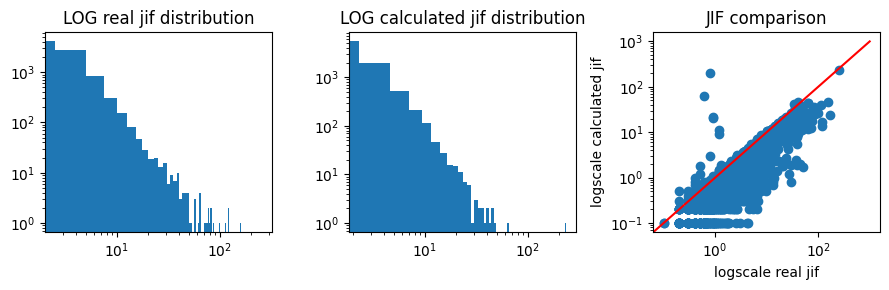

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(9,3))

ax[0].hist(comparison_df['real_jif'],bins=100)
ax[0].set_title('LOG real jif distribution')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].hist(comparison_df['jif'],bins=100)
ax[1].set_title('LOG calculated jif distribution')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[2].scatter(comparison_df['real_jif'],comparison_df['jif'])
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel('logscale calculated jif')
ax[2].set_xlabel('logscale real jif')
x_data = [0,10,100,1000]
y_data = [0,10,100,1000]
plt.plot(x_data, x_data, color = 'red', label = 'x=y')
ax[2].set_title('JIF comparison')

plt.tight_layout()
plt.savefig('jif_comparison.png')
plt.show()

## RMSE

We can also treat the comparison between our calculated JIF and the real JIF as a linear regression problem where 1 would be a perfect slope and 0 would be a perfect RMSE.

It makes more sense to compare the log transformations of both JIFs because although the RMSE diference between JIFs of 254 and 232 is much less of a diffence in terms of rank than between 0.1 and 0.6 for example.

In [ ]:
comparison_df['log_real_jif'] = np.log(comparison_df['real_jif'])
comparison_df['log_calc_jif'] = np.log(comparison_df['jif'])
comparison_df.replace([np.inf, -np.inf], 0, inplace=True)
print(min([min(comparison_df['log_real_jif']),min(comparison_df['log_real_jif'])]))
print(max([max(comparison_df['log_real_jif']),max(comparison_df['log_real_jif'])]))

-2.3025850929940455
5.540086381985411


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
model = LinearRegression()
x = [[val] for val in comparison_df['log_real_jif'].to_numpy()]
y = comparison_df['log_calc_jif']
model.fit(x, y)

LinearRegression()

In [ ]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"slope: {model.coef_}")
print(f"intercept: {model.intercept_}")

coefficient of determination: 0.7830413532384364
slope: [0.97522211]
intercept: -0.4238017793280696


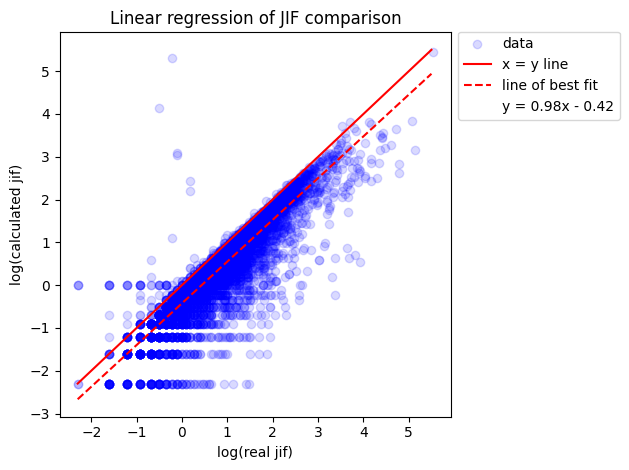

In [ ]:
# plot linear regression\

# plot log transformed data
plt.scatter(comparison_df['log_real_jif'],comparison_df['log_calc_jif'],color=[0,0,1,0.15])
plt.ylabel('log(calculated jif)')
plt.xlabel('log(real jif)')

# plot x=y line
x_data = np.linspace(-2.3,5.5,100)
y_data = np.linspace(-2.3,5.5,100)
plt.plot(x_data, x_data, color = 'red', label = 'x=y')

# linear regression model line
x = np.linspace(-2.3,5.5,100)
y = model.coef_*x+model.intercept_
plt.plot(x, y, '--r', label='y=2x+1')

plt.plot(-2,5,color=[0,0,0,0])

plt.title('Linear regression of JIF comparison')

plt.legend(['data','x = y line', 'line of best fit','y = 0.98x - 0.42'],bbox_to_anchor=(1.0, 1.02))

plt.tight_layout()
plt.savefig('jif_linear_regression.png')
plt.show()

In [ ]:
# mean squared error between calculated JIF and real JIF

mean_squared_error(comparison_df['log_calc_jif'],comparison_df['log_real_jif'])

0.3979647403428976

In [ ]:
dummy_model = [np.mean(comparison_df['log_calc_jif']) for v in comparison_df['log_calc_jif']]

mean_squared_error(dummy_model,comparison_df['log_real_jif'])

0.9494405132423948

In [ ]:
mean_squared_error(comparison_df['jif'],comparison_df['real_jif'])

25.458456431535268

In [ ]:
dummy_model = [np.mean(comparison_df['real_jif']) for v in comparison_df['real_jif']]

mean_squared_error(dummy_model,comparison_df['real_jif'])

47.24829832426144

### Outlier Analysis

In [ ]:
comparison_df = comparison_df[['Journal Title','ISSN','real_jif','citations22','workcount20_recalc','workcount21_recalc','jif','journal_id','log_real_jif','log_calc_jif']]
comparison_df[(comparison_df['log_real_jif']<1) & (comparison_df['log_calc_jif']>2)]

,Journal Title,ISSN,real_jif,citations22,workcount20_recalc,workcount21_recalc,jif,journal_id,log_real_jif,log_calc_jif
874889,Archives of Control Sciences,2300-2611,1.2,9,1,0,9.0,2736825055,0.182322,2.197225
874890,Archives of Mining Sciences,0860-7001,1.2,34,1,2,11.3,12999175,0.182322,2.424803
875443,Archives of Acoustics,0137-5075,0.9,44,1,1,22.0,146157322,-0.105361,3.091042
875492,Gospodarka Surowcami Mineralnymi-Mineral Resou...,0860-0953,0.9,21,0,1,21.0,1026706133,-0.105361,3.044522
875749,POLISH JOURNAL OF VETERINARY SCIENCES,1505-1773,0.8,202,1,0,202.0,79457278,-0.223144,5.308268
875981,ARCHIVES OF METALLURGY AND MATERIALS,1733-3490,0.6,63,1,0,63.0,20440071,-0.510826,4.143135


In [ ]:
comparison_df = comparison_df[['Journal Title','ISSN','real_jif','citations22','workcount20_recalc','workcount21_recalc','jif','journal_id','log_real_jif','log_calc_jif']]
comparison_df[(comparison_df['log_real_jif']>3) & (comparison_df['log_calc_jif']<1)]

,Journal Title,ISSN,real_jif,citations22,workcount20_recalc,workcount21_recalc,jif,journal_id,log_real_jif,log_calc_jif
25,ANNALS OF ONCOLOGY,0923-7534,50.5,12013,3641,3379,1.7,41454044,3.921973,0.530628
33,JOURNAL OF CLINICAL ONCOLOGY,0732-183X,45.3,27021,7436,6233,2.0,15137598,3.813307,0.693147
868054,EUROPEAN HEART JOURNAL,0195-668X,39.3,17075,4741,4266,1.9,181568219,3.671225,0.641854
868061,CIRCULATION,0009-7322,37.8,21122,4526,4383,2.4,116251202,3.632309,0.875469
868089,Gastroenterology,0016-5085,29.4,14570,4626,3166,1.9,143352558,3.380995,0.641854
868090,BEHAVIORAL AND BRAIN SCIENCES,0140-525X,29.3,320,177,201,0.8,59628311,3.377588,-0.223144
868102,ANNALS OF THE RHEUMATIC DISEASES,0003-4967,27.4,8738,4065,3097,1.2,25650217,3.310543,0.182322
868130,EUROPEAN UROLOGY,0302-2838,23.4,5900,499,1704,2.7,96871409,3.152736,0.993252
868132,COMMUNICATIONS OF THE ACM,0001-0782,22.7,1472,288,312,2.5,103482838,3.122365,0.916291
868149,Journal of Thoracic Oncology,1556-0864,20.4,5631,500,2701,1.8,90745127,3.015535,0.587787


### Measure bias in the JIF towards certain discciplines

In [ ]:
comparison_df

,Journal Title,ISSN,real_jif,citations22,workcount20_recalc,workcount21_recalc,journal_id,main_concept,work_count_20_21,issn_merge,eISSN,jif,ISSN_x,ISSN_y
0,PSYCHIATRIE DE L ENFANT,0079-726X,0.0,1,30,22,4210223661,Philosophy,52,0079-726X,2102-5320,0.0,NaN,NaN
1,CA-A CANCER JOURNAL FOR CLINICIANS,0007-9235,254.7,27164,68,49,126094547,Medicine,117,1542-4863,1542-4863,232.2,NaN,NaN
2,LANCET,0140-6736,168.9,71939,1583,1497,49861241,Medicine,3080,1474-547X,1474-547X,23.4,NaN,NaN
3,NEW ENGLAND JOURNAL OF MEDICINE,0028-4793,158.5,93864,1041,974,62468778,Medicine,2015,0028-4793,1533-4406,46.6,NaN,NaN
4,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,0098-7484,120.7,42762,1620,1476,172573765,Medicine,3096,0098-7484,1538-3598,13.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874295,BIOLOGICHESKIE MEMBRANY,0233-4755,0.1,4,40,35,56451558,Chemistry,75,0233-4755,NaN,0.1,NaN,NaN
874296,Hidrobiologica,0188-8897,0.1,3,40,29,145577349,Biology,69,None,0188-8897,0.0,NaN,NaN
874297,INTERNATIONAL JOURNAL OF HUMAN GENETICS,0972-3757,0.1,2,26,23,65503661,Biology,49,0972-3757,2456-6330,0.0,NaN,NaN
874298,INTERNATIONAL SURGERY,0020-8868,0.1,2,28,58,10710138,Medicine,86,0020-8868,2520-2456,0.0,NaN,NaN


In [ ]:
comparison_df.dropna(inplace=True,axis=0,subset=['main_concept'])

In [ ]:
sum(comparison_df['main_concept'].isna())

0

In [ ]:
comparison_df['real_jif'].quantile(0.95)

10.5

In [ ]:
disciplines = comparison_df['main_concept'].unique().tolist()

dict_to_plot = {}

for disc in tqdm(disciplines):
  # filter df to only contain one discipline
  temp = comparison_df[comparison_df['main_concept']==disc]
  # proportion of this discipline with JIF > 2.6
  prop = len(temp[temp['real_jif']>10.5])/len(temp)
  # save
  dict_to_plot[disc] = prop

100%|██████████| 19/19 [00:00<00:00, 171.83it/s]


In [ ]:
from collections import OrderedDict

dict_to_plot = {k: v for k, v in sorted(dict_to_plot.items(), key=lambda item: item[1])}
dict_to_plot = OrderedDict(reversed(list(dict_to_plot.items())))
dict_to_plot

OrderedDict([('Business', 0.14285714285714285),
             ('Materials science', 0.10054347826086957),
             ('Chemistry', 0.06339144215530904),
             ('Psychology', 0.06222222222222222),
             ('Biology', 0.059),
             ('Environmental science', 0.05714285714285714),
             ('Medicine', 0.05340399510803098),
             ('Physics', 0.04340567612687813),
             ('Computer science', 0.041168658698539175),
             ('Engineering', 0.04046242774566474),
             ('Economics', 0.020833333333333332),
             ('Geology', 0.01718213058419244),
             ('Mathematics', 0.0019646365422396855),
             ('Art', 0.0),
             ('History', 0.0),
             ('Sociology', 0.0),
             ('Political science', 0.0),
             ('Geography', 0.0),
             ('Philosophy', 0.0)])

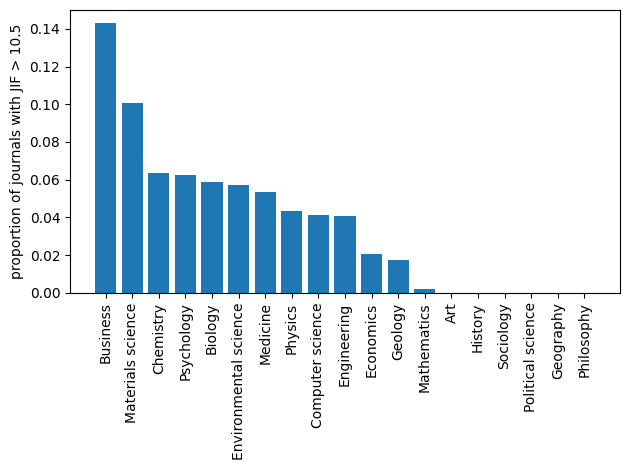

In [ ]:
plt.bar(dict_to_plot.keys(),dict_to_plot.values())
plt.xticks(rotation=90)
plt.ylabel('proportion of journals with JIF > 10.5')
plt.tight_layout()
plt.savefig('jif_bias.png')
plt.show()